# inspect_plant_model

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import plant

%matplotlib inline 

# Directory to save logs and trained model
LOGS_DIR = os.path.join(ROOT_DIR, "logs")

/home/mary/AI/Projects/Arobdopsis/Mask_RCNN


Using TensorFlow backend.


In [2]:
# Dataset directory
Data_dir='/home/mary/AI/data/arabidopsis/synthetic_arabidopsis_dataset/'
DATASET_DIR = Data_dir

# Inference Configuration
config = plant.PlantConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [3]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# Only inference mode is supported right now
TEST_MODE = "inference"

In [4]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    fig.tight_layout()
    return ax

## Load Validation Dataset

In [5]:
# Load validation dataset
dataset = plant.PlantDataset()
dataset.load_plant(DATASET_DIR, "val")
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 2004
Classes: ['BG', 'plant']


## Load Model

In [7]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference",
                              model_dir=LOGS_DIR,
                              config=config)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [8]:
weights_path = model.find_last()
print (weights_path)

/home/mary/AI/Projects/Arobdopsis/Mask_RCNN/logs/plant20200106T0124/mask_rcnn_plant_0070.h5


In [9]:
weights_path_public='/home/mary/AI/Projects/Arobdopsis/model/leafSegmenter0005.h5'

In [10]:
model.load_weights(weights_path, by_name=True)

Re-starting from epoch 70


## Run Detection

image ID: plant.plant04084_rgb (1599) plant04084_rgb
Original image shape:  [550 550   3]
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  143.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  143.00000  uint8
image_metas              shape: (1, 14)               min:    0.00000  max: 1599.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
gt_class_id              shape: (16,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (16, 4)               min:  101.00000  max:  485.00000  int32
gt_mask                  shape: (512, 512, 16)        min:    0.00000  max:    1.00000  bool
AP @0.50:	 0.750
AP @0.55:	 0.688
AP @0.60:	 0.619
AP @0.65:	 0.562
AP @0.70:	 0.562
AP @0.75:	 0.562
AP @0.80:	 0.562
AP @0.85:	 0.312
AP @0.90:	 0.107
AP @0.95:	 0.000
AP @0.50-0.95:	 0.473


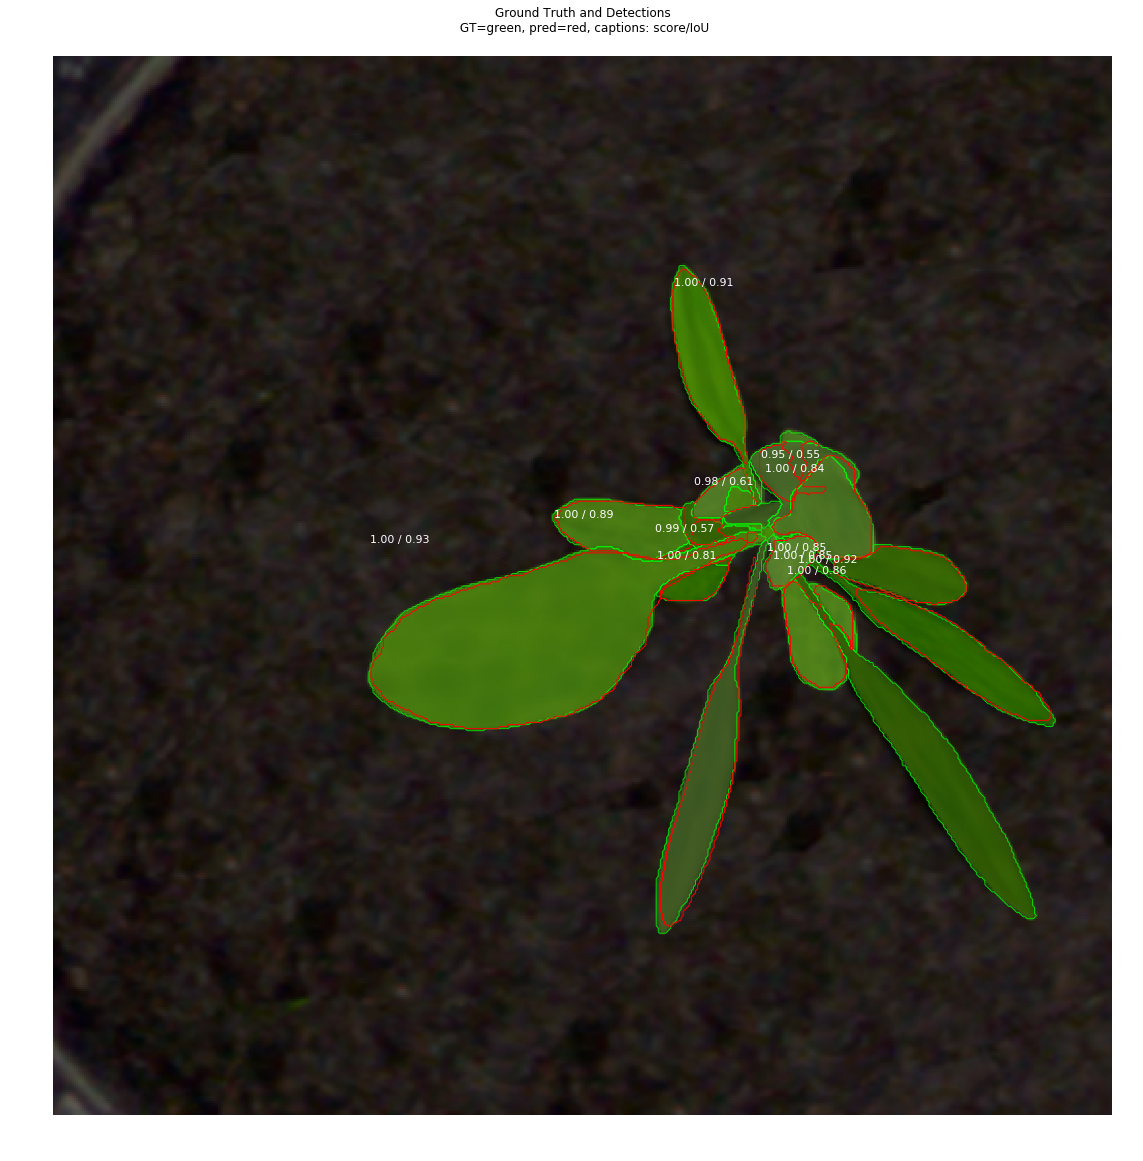

In [16]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

# Run object detection
results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)

# Display results
r = results[0]
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# Compute AP over range 0.5 to 0.95 and print it
utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                       r['rois'], r['class_ids'], r['scores'], r['masks'],
                       verbose=1)

visualize.display_differences(
    image,
    gt_bbox, gt_class_id, gt_mask,
    r['rois'], r['class_ids'], r['scores'], r['masks'],
    dataset.class_names, ax=get_ax(),
    show_box=False, show_mask=False,
    iou_threshold=0.5, score_threshold=0.5)

In [17]:
def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        ap = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        APs.append(ap)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap))
    return APs

# Run on validation set
limit = 5
APs = compute_batch_ap(dataset, dataset.image_ids[:limit])
print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))

  0 [550 550   3]   AP: 0.35
  1 [550 550   3]   AP: 0.38
  2 [550 550   3]   AP: 0.35
  3 [550 550   3]   AP: 0.45
  4 [550 550   3]   AP: 0.52
Mean AP overa 5 images: 0.4082


## Step by Step Prediction

### Stage 1: Region Proposal Network



The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high objectness score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.


1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely

In [21]:
# Get anchors and convert to pixel coordinates
anchors = model.get_anchors(image.shape)
print(image.shape)
anchors = utils.denorm_boxes(anchors, image.shape[:2])
log("anchors", anchors)

# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = anchors[positive_anchor_ix]
negative_anchors = anchors[negative_anchor_ix]
neutral_anchors = anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )

(512, 512, 3)
anchors                  shape: (65472, 4)            min:  -91.00000  max:  539.00000  int32
target_rpn_match         shape: (65472,)              min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (256, 4)              min:   -3.38889  max:    2.95455  float64
positive_anchors         shape: (17, 4)               min:  115.00000  max:  512.00000  int32
negative_anchors         shape: (239, 4)              min:  -45.00000  max:  515.00000  int32
neutral anchors          shape: (65216, 4)            min:  -91.00000  max:  539.00000  int32
refined_anchors          shape: (17, 4)               min:  101.00000  max:  485.00000  float32


[Mary Note]:
The above anchors' number can be:

P2:512/4(stride)=128, anchor_num=128x128x3

P3:512/8=64,anchor_num=64x64x3

P4:512/16=32, anchor_num=32x32x3

P5:512/32=16,anchor_num=16x16x3

P6:512/32=8, anchor_num=8x8x3

Sum(P2+P3+P4+P5+P6)=65472
-------------------------------------------------------

Also note that:
   RPN_TRAIN_ANCHORS_PER_IMAGE = 256
so target_rpn_bbox.shape=(256,4)

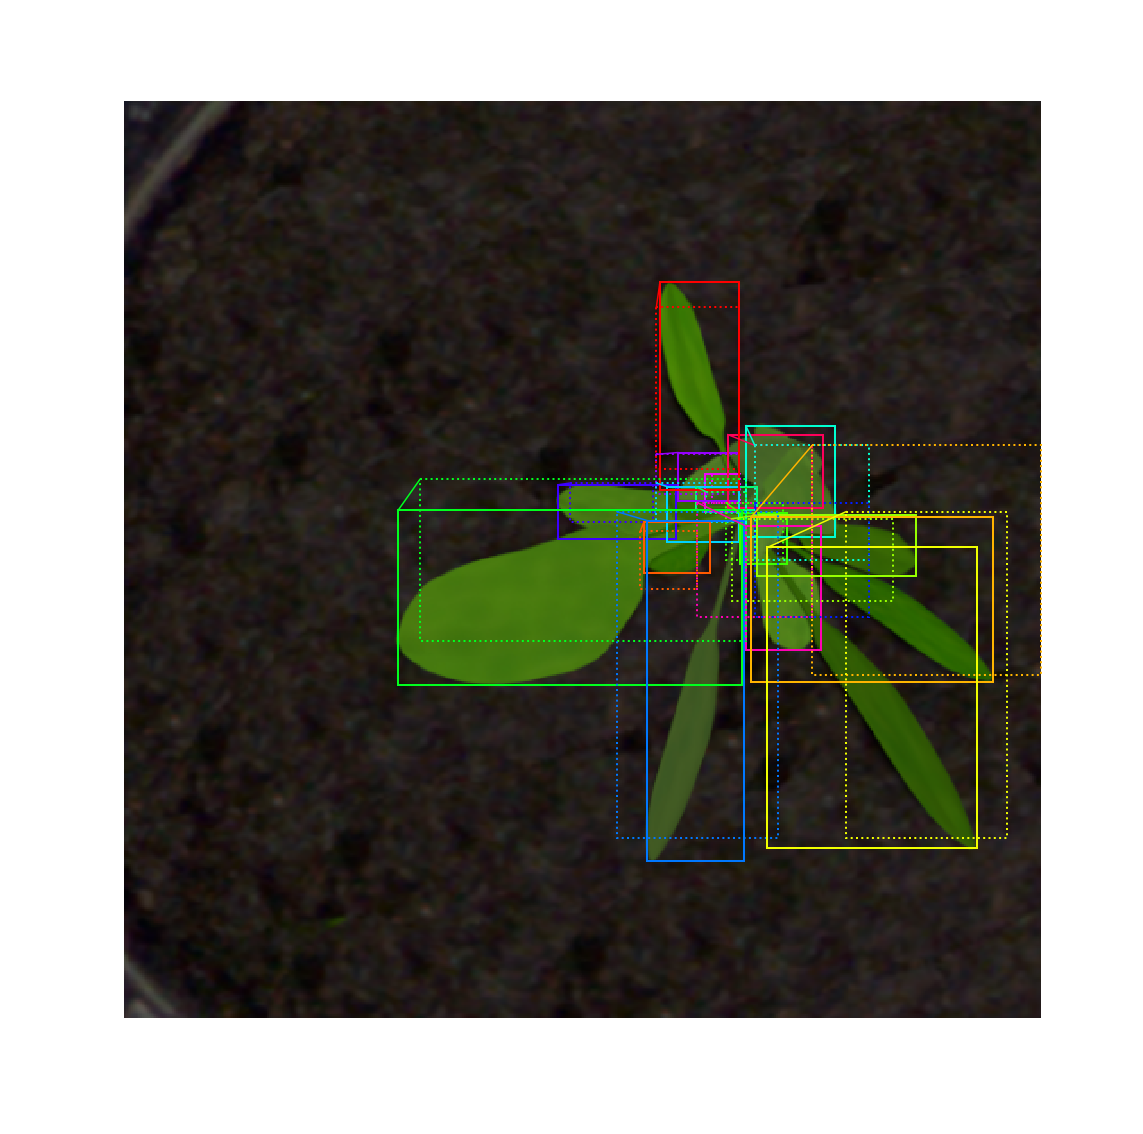

In [22]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(
    image, ax=get_ax(),
    boxes=positive_anchors,
    refined_boxes=refined_anchors)

1.b RPN Predictions

In [23]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph(image[np.newaxis], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
], image_metas=image_meta[np.newaxis])

rpn_class                shape: (1, 65472, 2)         min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 6000, 4)          min:   -0.17712  max:    1.05188  float32
refined_anchors          shape: (1, 6000, 4)          min:  -54.46672  max:   55.68909  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (1000,)               min:    0.00000  max: 3463.00000  int32
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


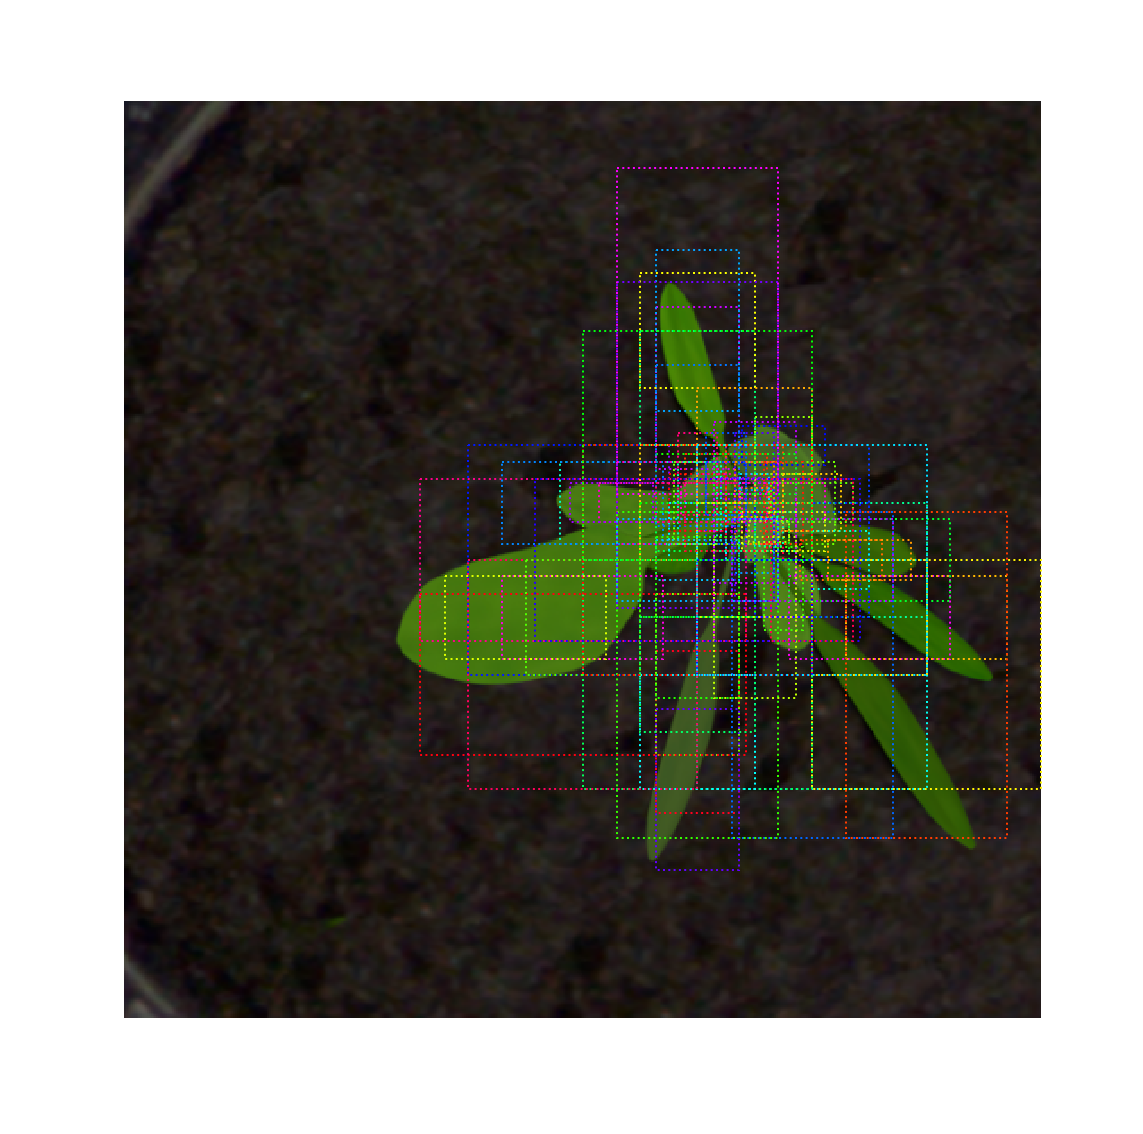

In [24]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=anchors[sorted_anchor_ids[:limit]], ax=get_ax())

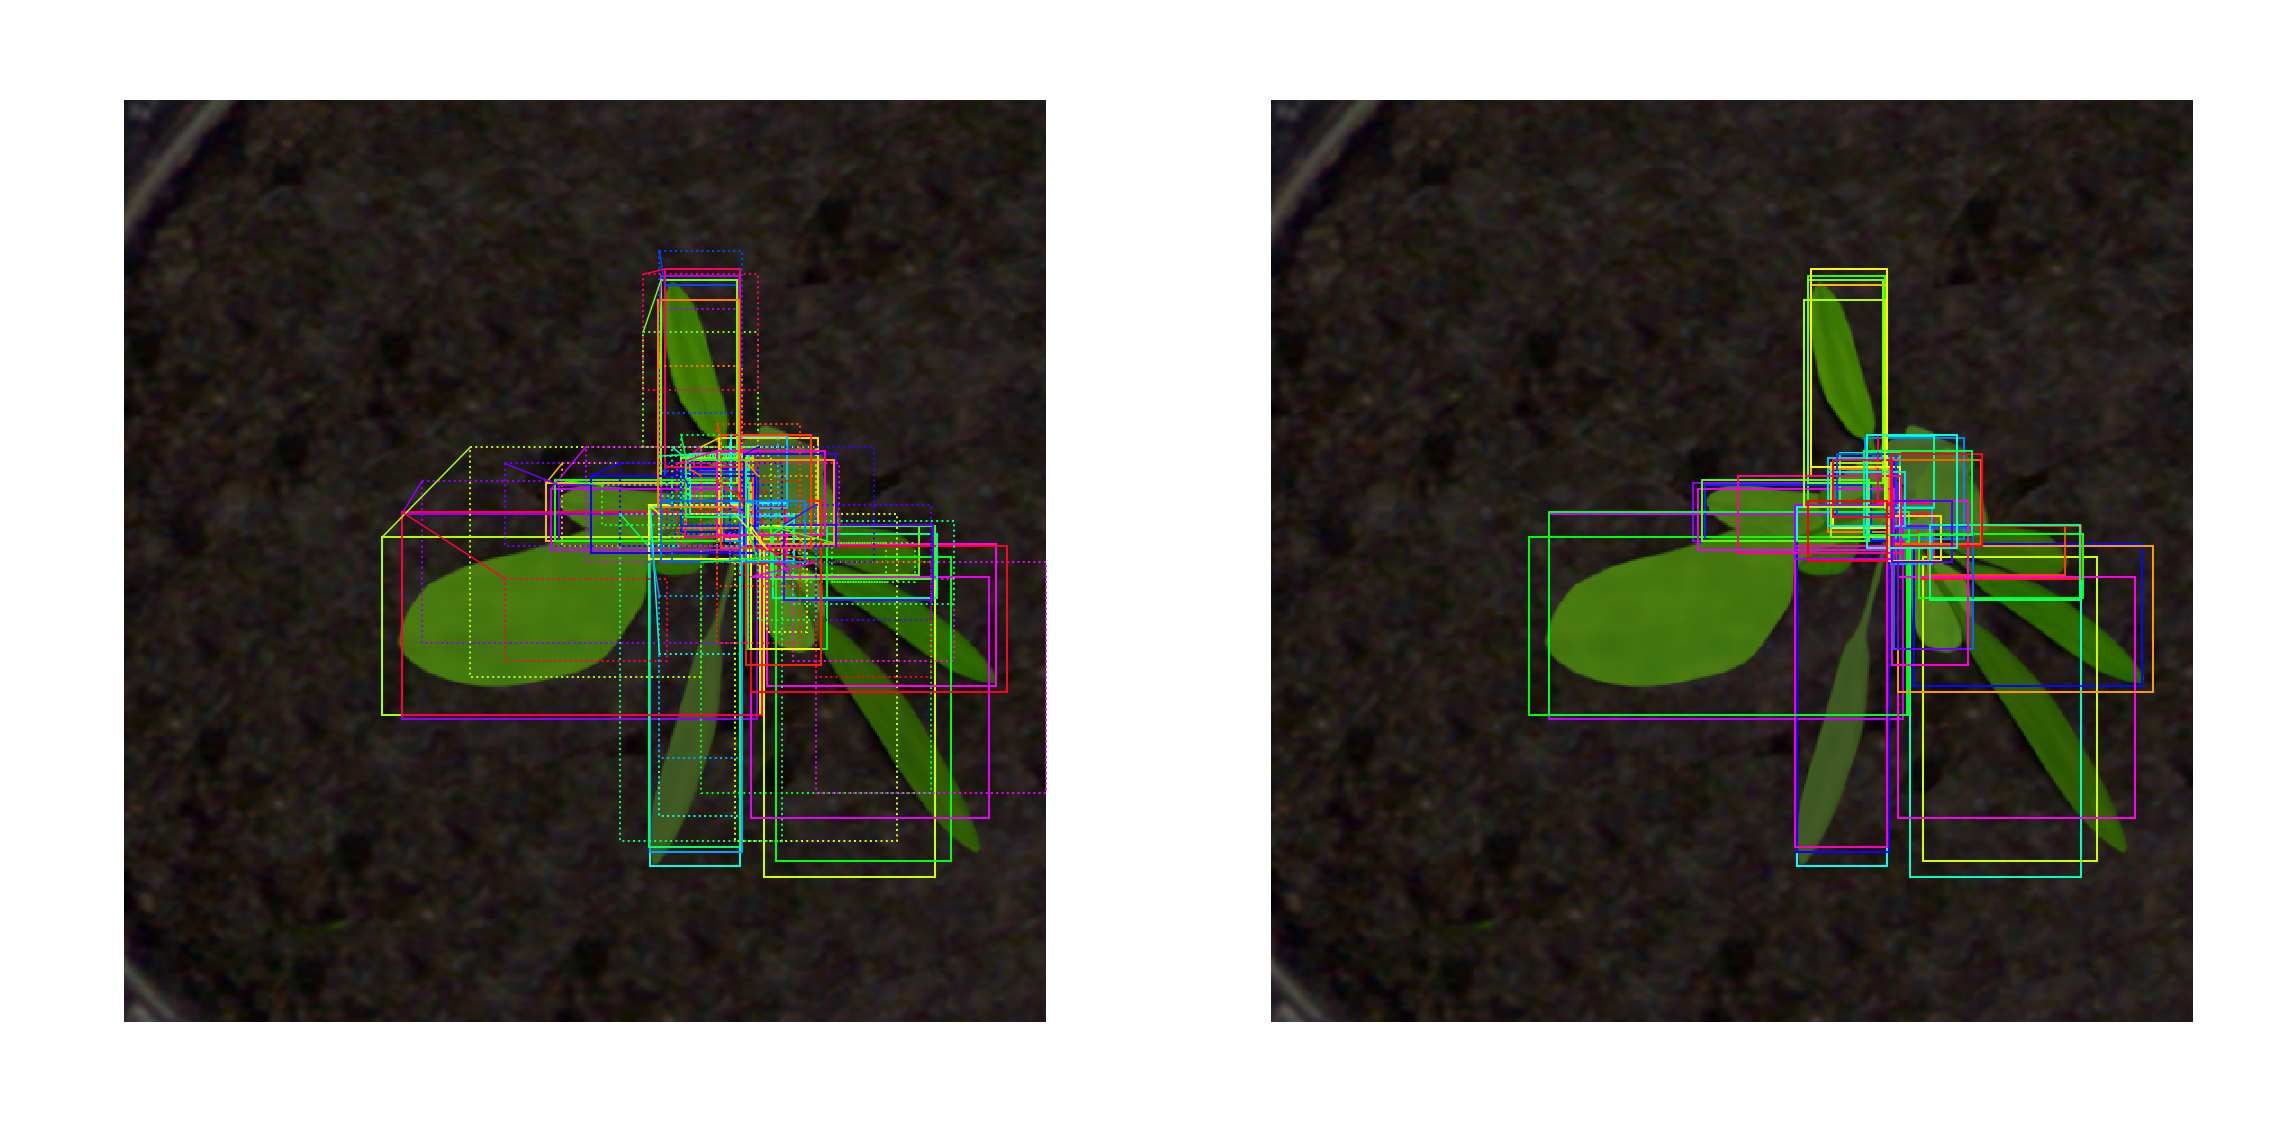

In [25]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 50
ax = get_ax(1, 2)
pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])

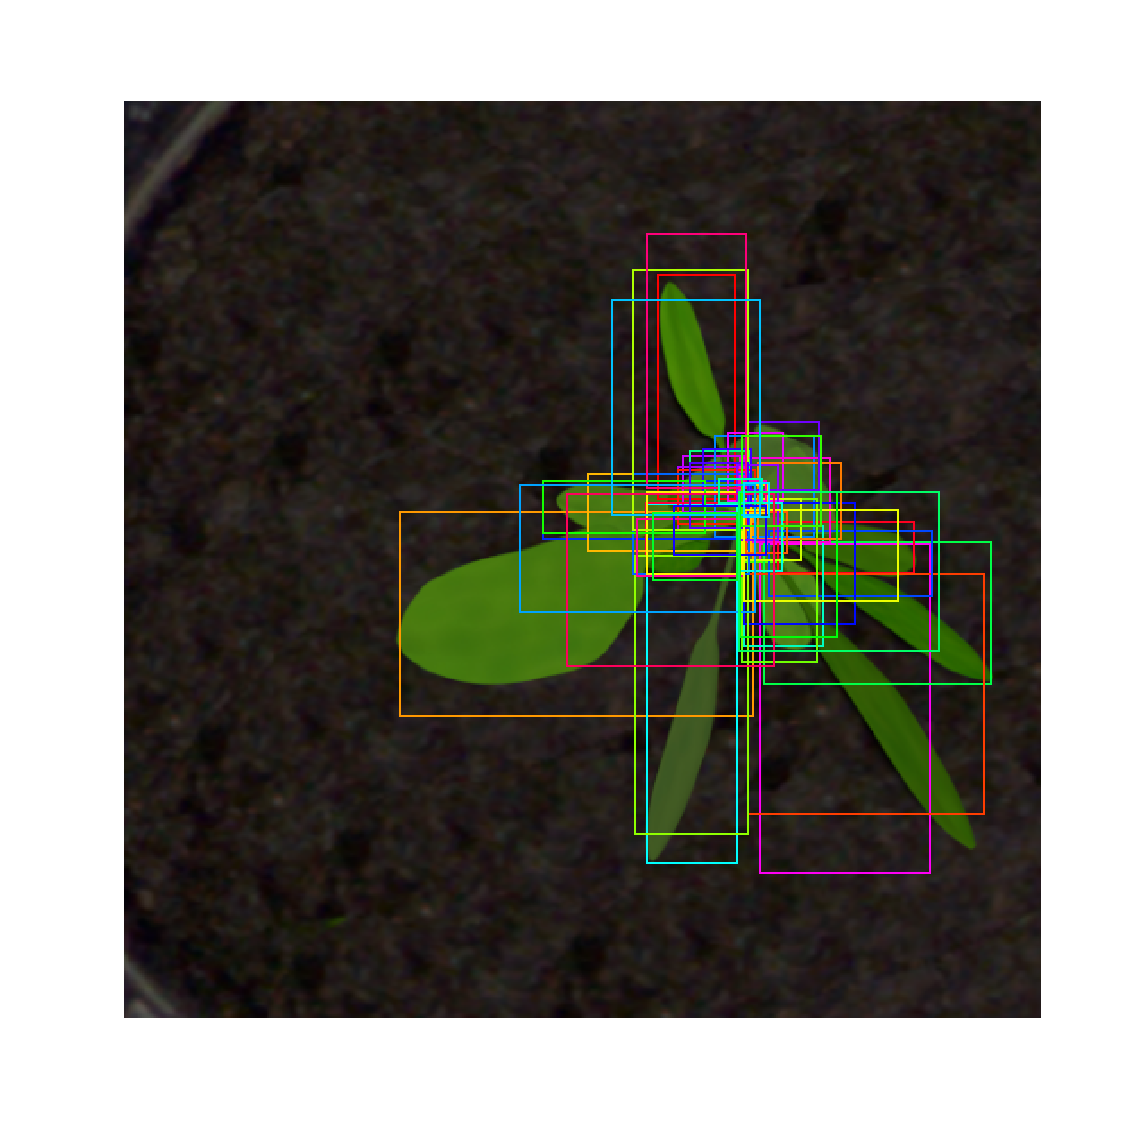

In [26]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())

### Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

In [29]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 1000, 2)          min:    0.00000  max:    1.00000  float32
deltas                   shape: (1, 1000, 2, 4)       min:   -3.76766  max:    3.46079  float32
masks                    shape: (1, 100, 28, 28, 2)   min:    0.00000  max:    1.00000  float32
detections               shape: (1, 100, 6)           min:    0.00000  max:    1.00000  float32


13 detections: ['plant' 'plant' 'plant' 'plant' 'plant' 'plant' 'plant' 'plant' 'plant'
 'plant' 'plant' 'plant' 'plant']


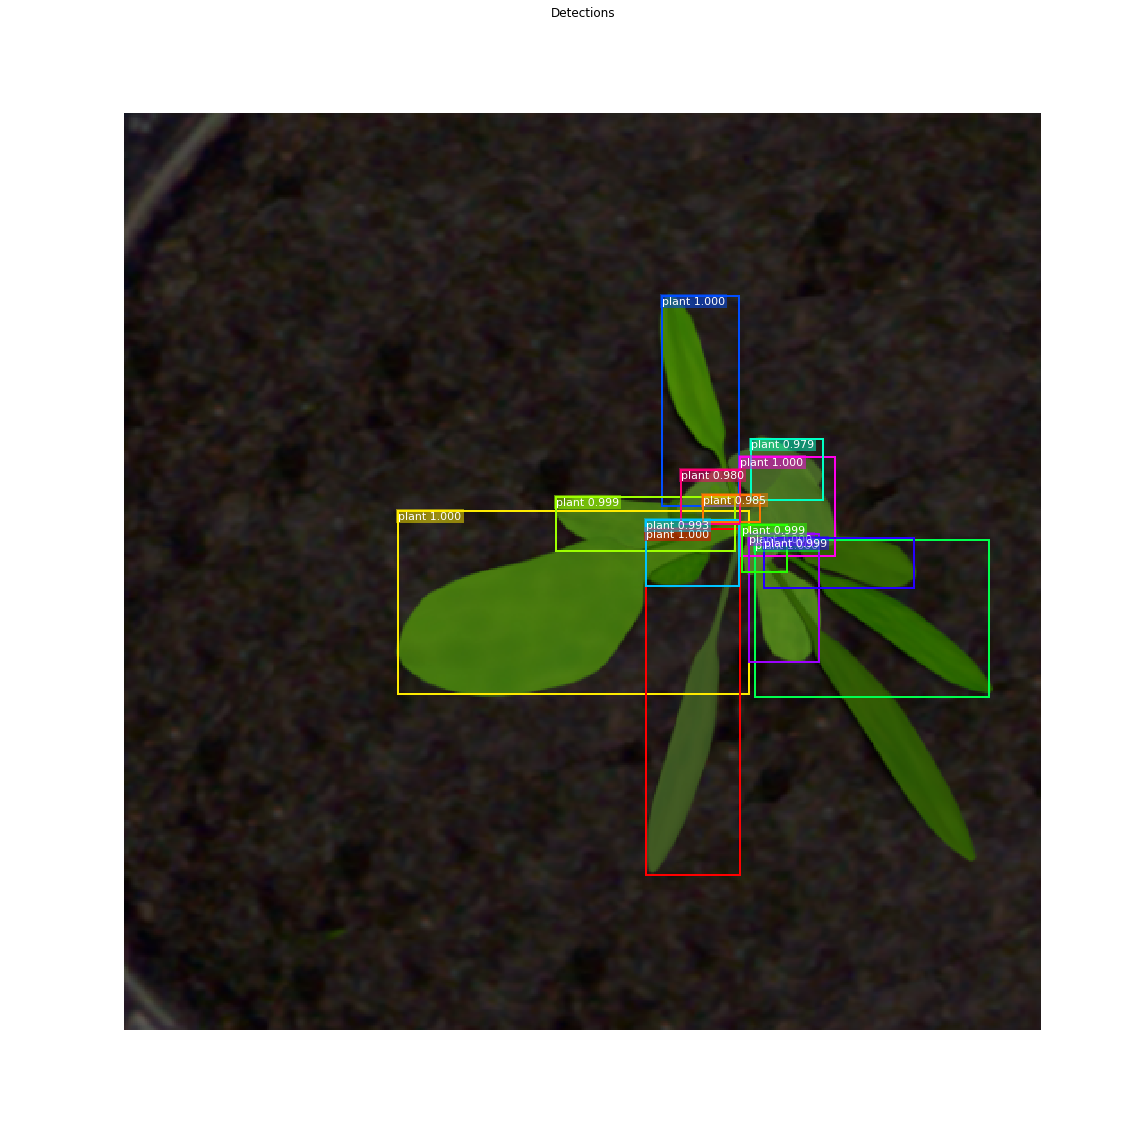

In [30]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

2.c Step by Step Detection

In [31]:
# Proposals are in normalized coordinates
proposals = mrcnn["proposals"][0]

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

1000 Valid proposals out of 1000
134 Positive ROIs
[('BG', 866), ('plant', 134)]


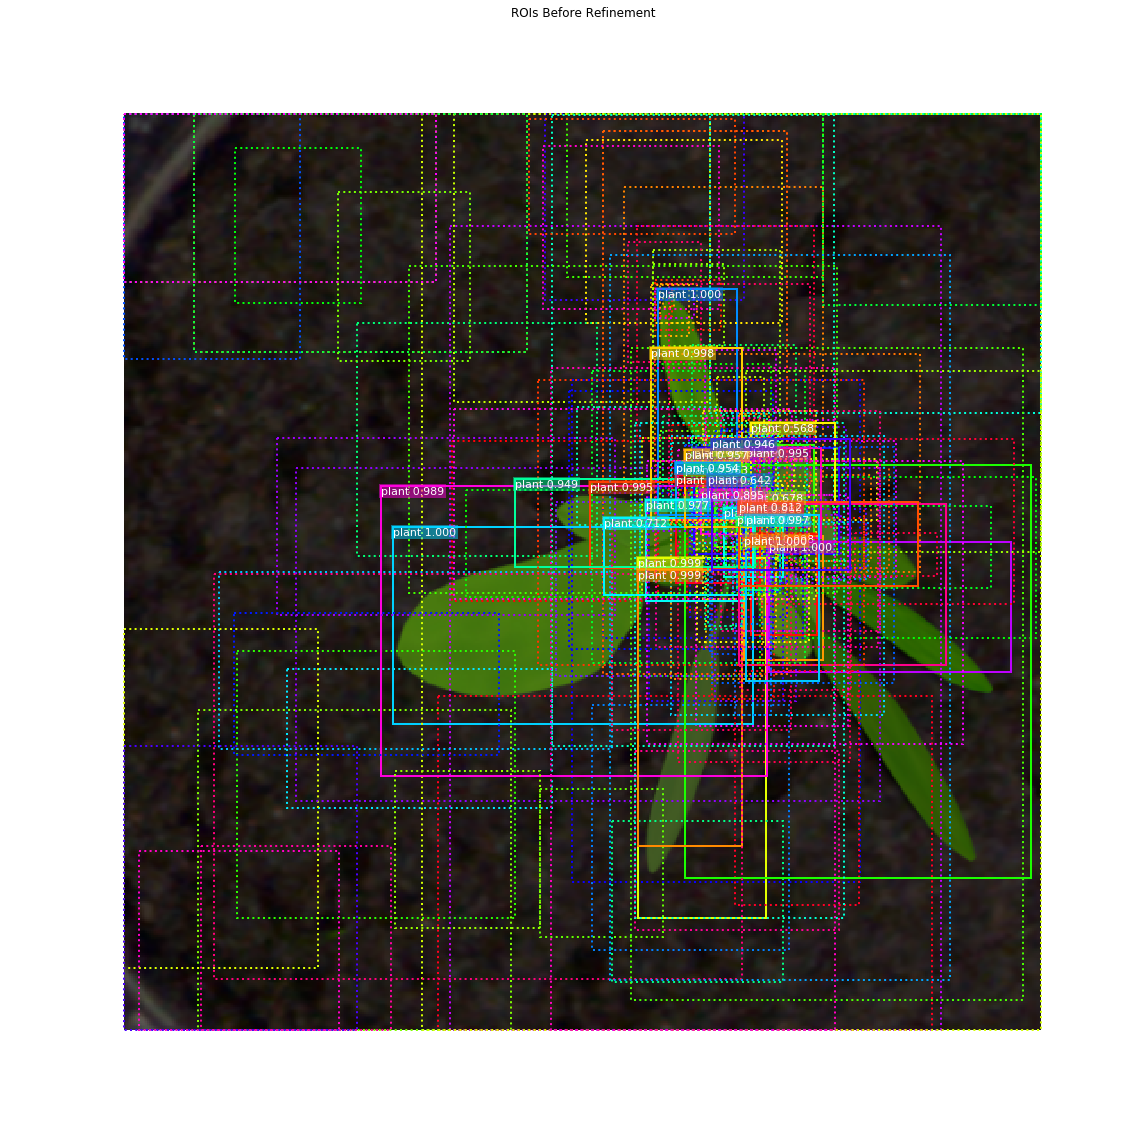

In [32]:
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(
    image,
    boxes=utils.denorm_boxes(proposals[ixs], image.shape[:2]),
    visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
    captions=captions, title="ROIs Before Refinement",
    ax=get_ax())

Apply Bounding Box Refinement

roi_bbox_specific        shape: (1000, 4)             min:   -3.76766  max:    3.46079  float32
refined_proposals        shape: (1000, 4)             min:   -0.00045  max:    1.00125  float32


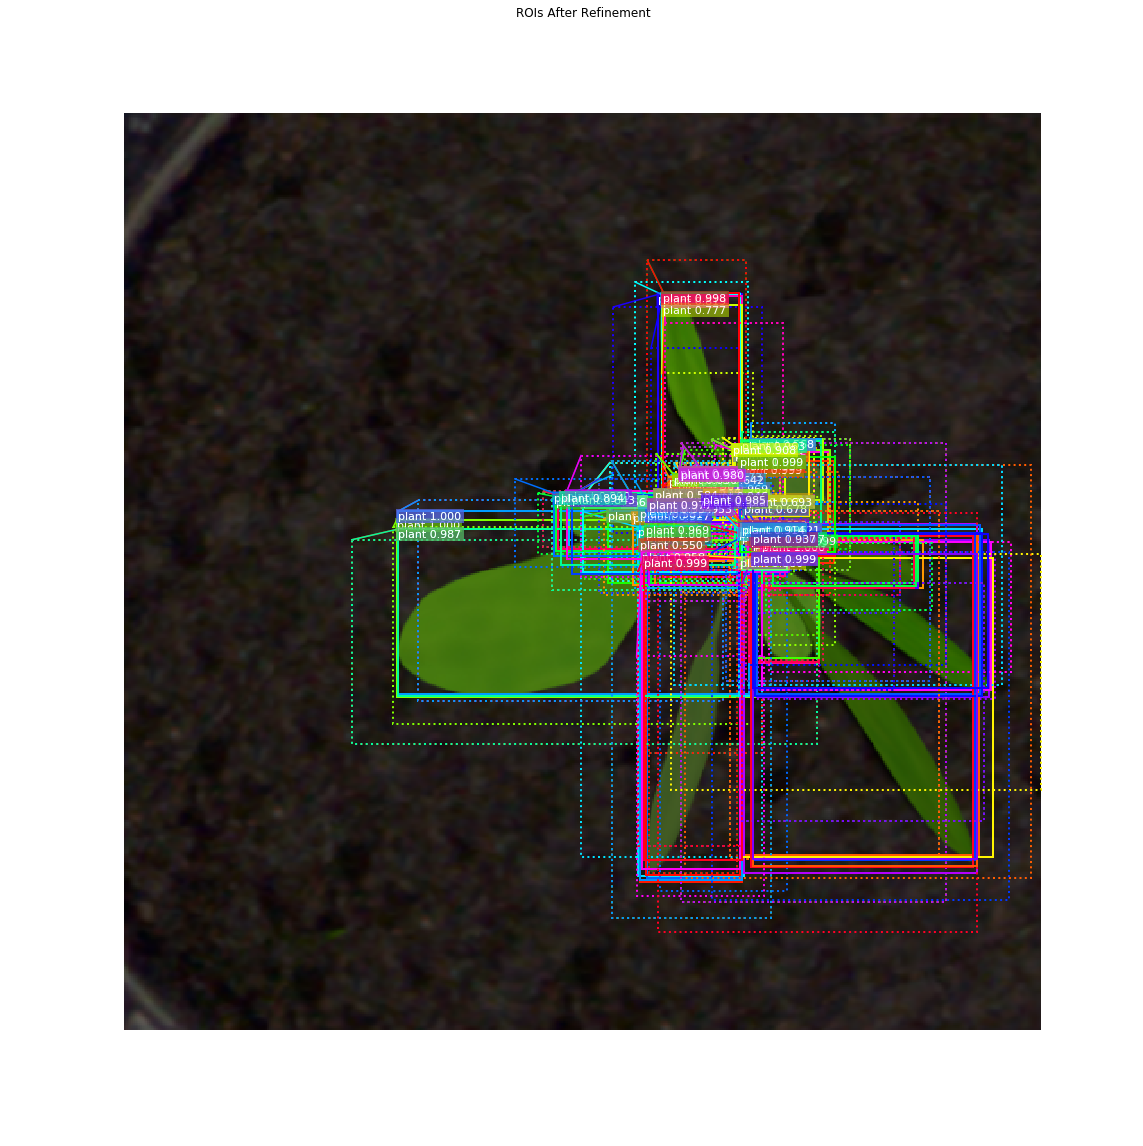

In [36]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 200
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(
    image, ax=get_ax(),
    boxes=utils.denorm_boxes(proposals[roi_positive_ixs][ids], image.shape[:2]),
    refined_boxes=utils.denorm_boxes(refined_proposals[roi_positive_ixs][ids], image.shape[:2]),
    visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
    captions=captions, title="ROIs After Refinement")

Filter Low Confidence Detections

In [37]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 134 detections:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  21  22  23  24  25  26  27  29  31  32  33  34  35  37  38  39
  40  41  43  44  45  46  48  49  50  54  56  59  60  64  66  67  69  70
  72  73  77  78  80  83  84  87  88  89  97  99 106 118 121 123 136 137
 138 151 156 169 170 173 174 176 177 179 180 181 195 200 201 202 206 208
 211 212 222 224 234 237 238 241 253 257 283 285 287 290 291 309 318 325
 327 340 346 349 361 362 375 383 386 403 411 429 430 434 447 456 462 486
 488 492 513 546 635 766 875 907]


Per-Class Non-Max Suppression

In [38]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

plant                 : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  21  22  23  24  25  26  27  29  31  32  33  34  35  37  38  39
  40  41  43  44  45  46  48  49  50  54  56  59  60  64  66  67  69  70
  72  73  77  78  80  83  84  87  88  89  97  99 106 118 121 123 136 137
 138 151 156 169 170 173 174 176 177 179 180 181 195 200 201 202 206 208
 211 212 222 224 234 237 238 241 253 257 283 285 287 290 291 309 318 325
 327 340 346 349 361 362 375 383 386 403 411 429 430 434 447 456 462 486
 488 492 513 546 635 766 875 907] -> [  6  23   2   3  17  13  60   7   0  44  66   8  11 138]

Kept after per-class NMS: 14
[  0   2   3   6   7   8  11  13  17  23  44  60  66 138]


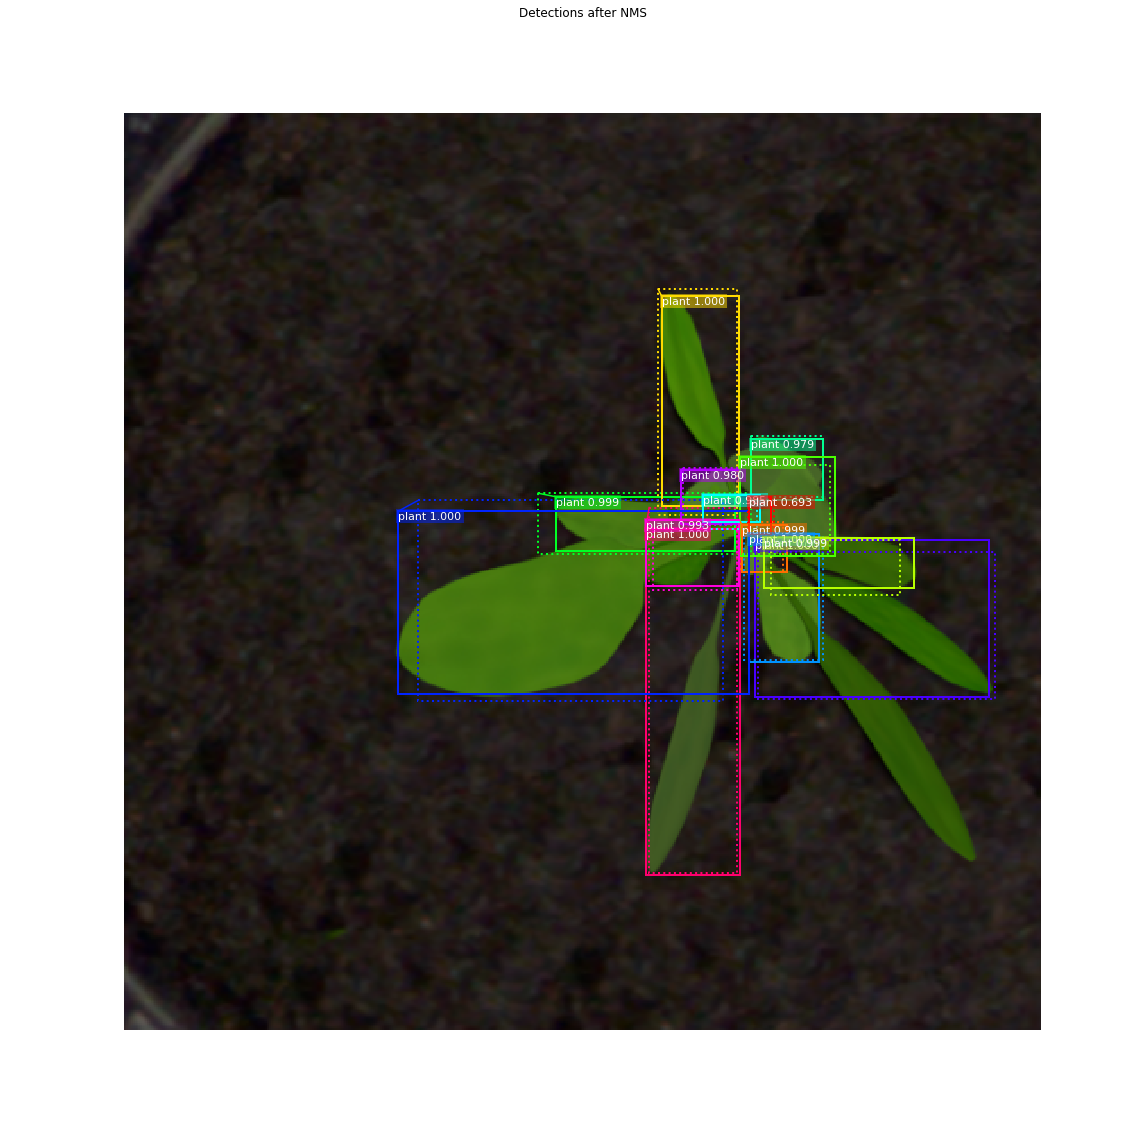

In [39]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image,
    boxes=utils.denorm_boxes(proposals[keep][ixs], image.shape[:2]),
    refined_boxes=utils.denorm_boxes(refined_proposals[keep][ixs], image.shape[:2]),
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

3.a Mask Targets
These are the training targets for the mask branch

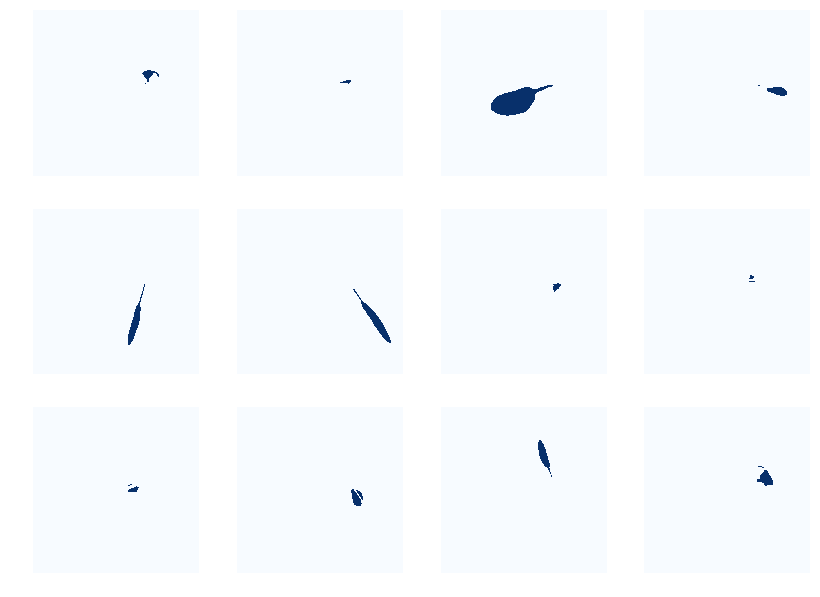

In [49]:
limit = 12
display_images(np.transpose(gt_mask[..., :limit], [2, 0, 1]), cmap="Blues")

3.b Predicted Masks

In [43]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

detections               shape: (1, 100, 6)           min:    0.00000  max:    1.00000  float32
masks                    shape: (1, 100, 28, 28, 2)   min:    0.00000  max:    1.00000  float32
13 detections: ['plant' 'plant' 'plant' 'plant' 'plant' 'plant' 'plant' 'plant' 'plant'
 'plant' 'plant' 'plant' 'plant']


In [44]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (13, 28, 28)          min:    0.00000  max:    1.00000  float32
det_masks                shape: (13, 512, 512)        min:    0.00000  max:    1.00000  bool


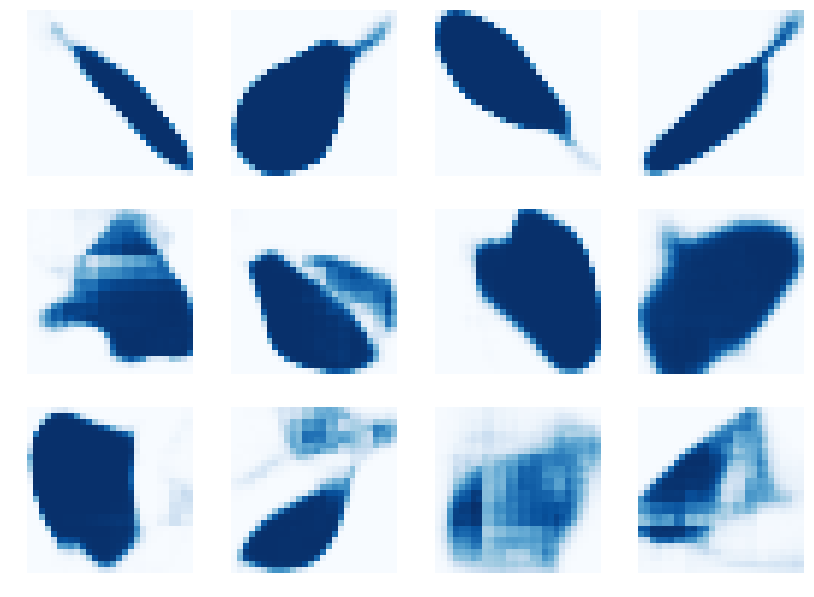

In [50]:
display_images(det_mask_specific[:12] * 255, cmap="Blues", interpolation="none")

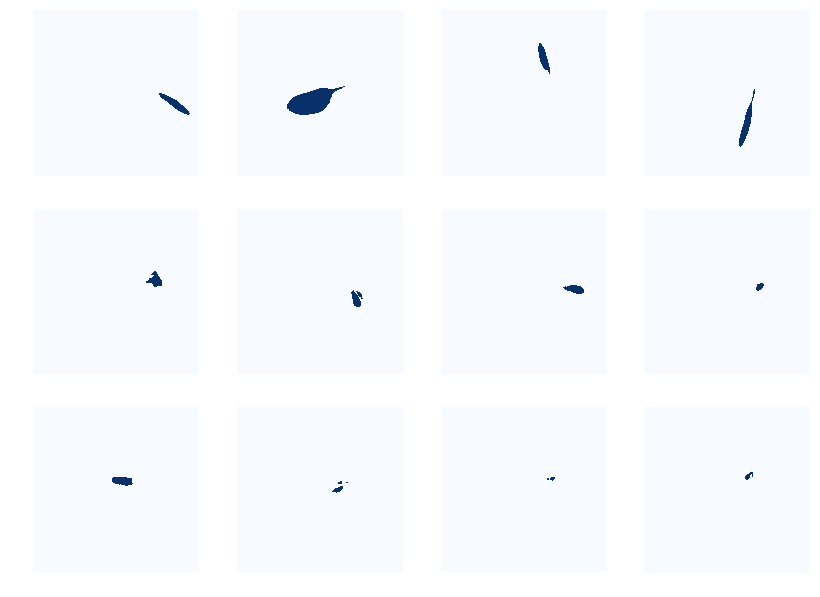

In [51]:
display_images(det_masks[:12] * 255, cmap="Blues", interpolation="none")